In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sys.path.append('../src/')
sys.path.append("../../scripts/")
from plt_config import use_latex, TU_GREY, TU_RED
use_latex()
sns.set_palette(plt.rcParams["axes.prop_cycle"].by_key()["color"])


Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [2]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    # val=0.1, # using 80% training / 10 % val / 10% test split
    # test=0.1
)

In [3]:
test_n = [(dataset.molecule(x).natm, x) for x in dataset.test_keys]
test_n = sorted(test_n, key=lambda x: x[0])

In [4]:
from time import time
from pyscf import gto, dft
times = []
basis_functions = []
for basis in ['pcseg-1', 'pcseg-3', 'pcseg-4']:
    print(f"Using basis set: {basis}")
    mol = gto.M(
        atom = """
        O  0.000000   0.000000   0.000000
        H  0.000000  -0.757000   0.587000
        H  0.000000   0.757000   0.587000
        """,
        basis = basis,
        unit  = 'angstrom',
    )

    # set up and run an unrestricted Kohn-Sham DFT

    start_ = time()
    mf = dft.RKS(mol)
    # number orbitals
    basis_functions.append(mol.nao)
    mf.xc = 'B3LYP'        # exchange-correlation functional
    energy = mf.kernel()   # runs the SCF
    end_ = time()
    times.append(1000*(end_ - start_))
print("Times for different basis sets:", times)


Using basis set: pcseg-1
converged SCF energy = -64.9247534241437
Using basis set: pcseg-3


/home/etschgi1/miniconda3/envs/scf_guess_1_0/lib/python3.11/site-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -76.4739113641632
Using basis set: pcseg-4
converged SCF energy = -76.4741966214829
Times for different basis sets: [183.6261749267578, 1090.4757976531982, 5149.2345333099365]


In [5]:
print(basis_functions)
print(times)
times = times

[24, 126, 223]
[183.6261749267578, 1090.4757976531982, 5149.2345333099365]


Polynomial coefficients: [8.53457807e-07 1.53877498e-04 2.05808815e-02 7.00469019e-01
 1.52549971e+02]


/tmp/ipykernel_5902/2759346835.py:2: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(basis_functions, times, 4)


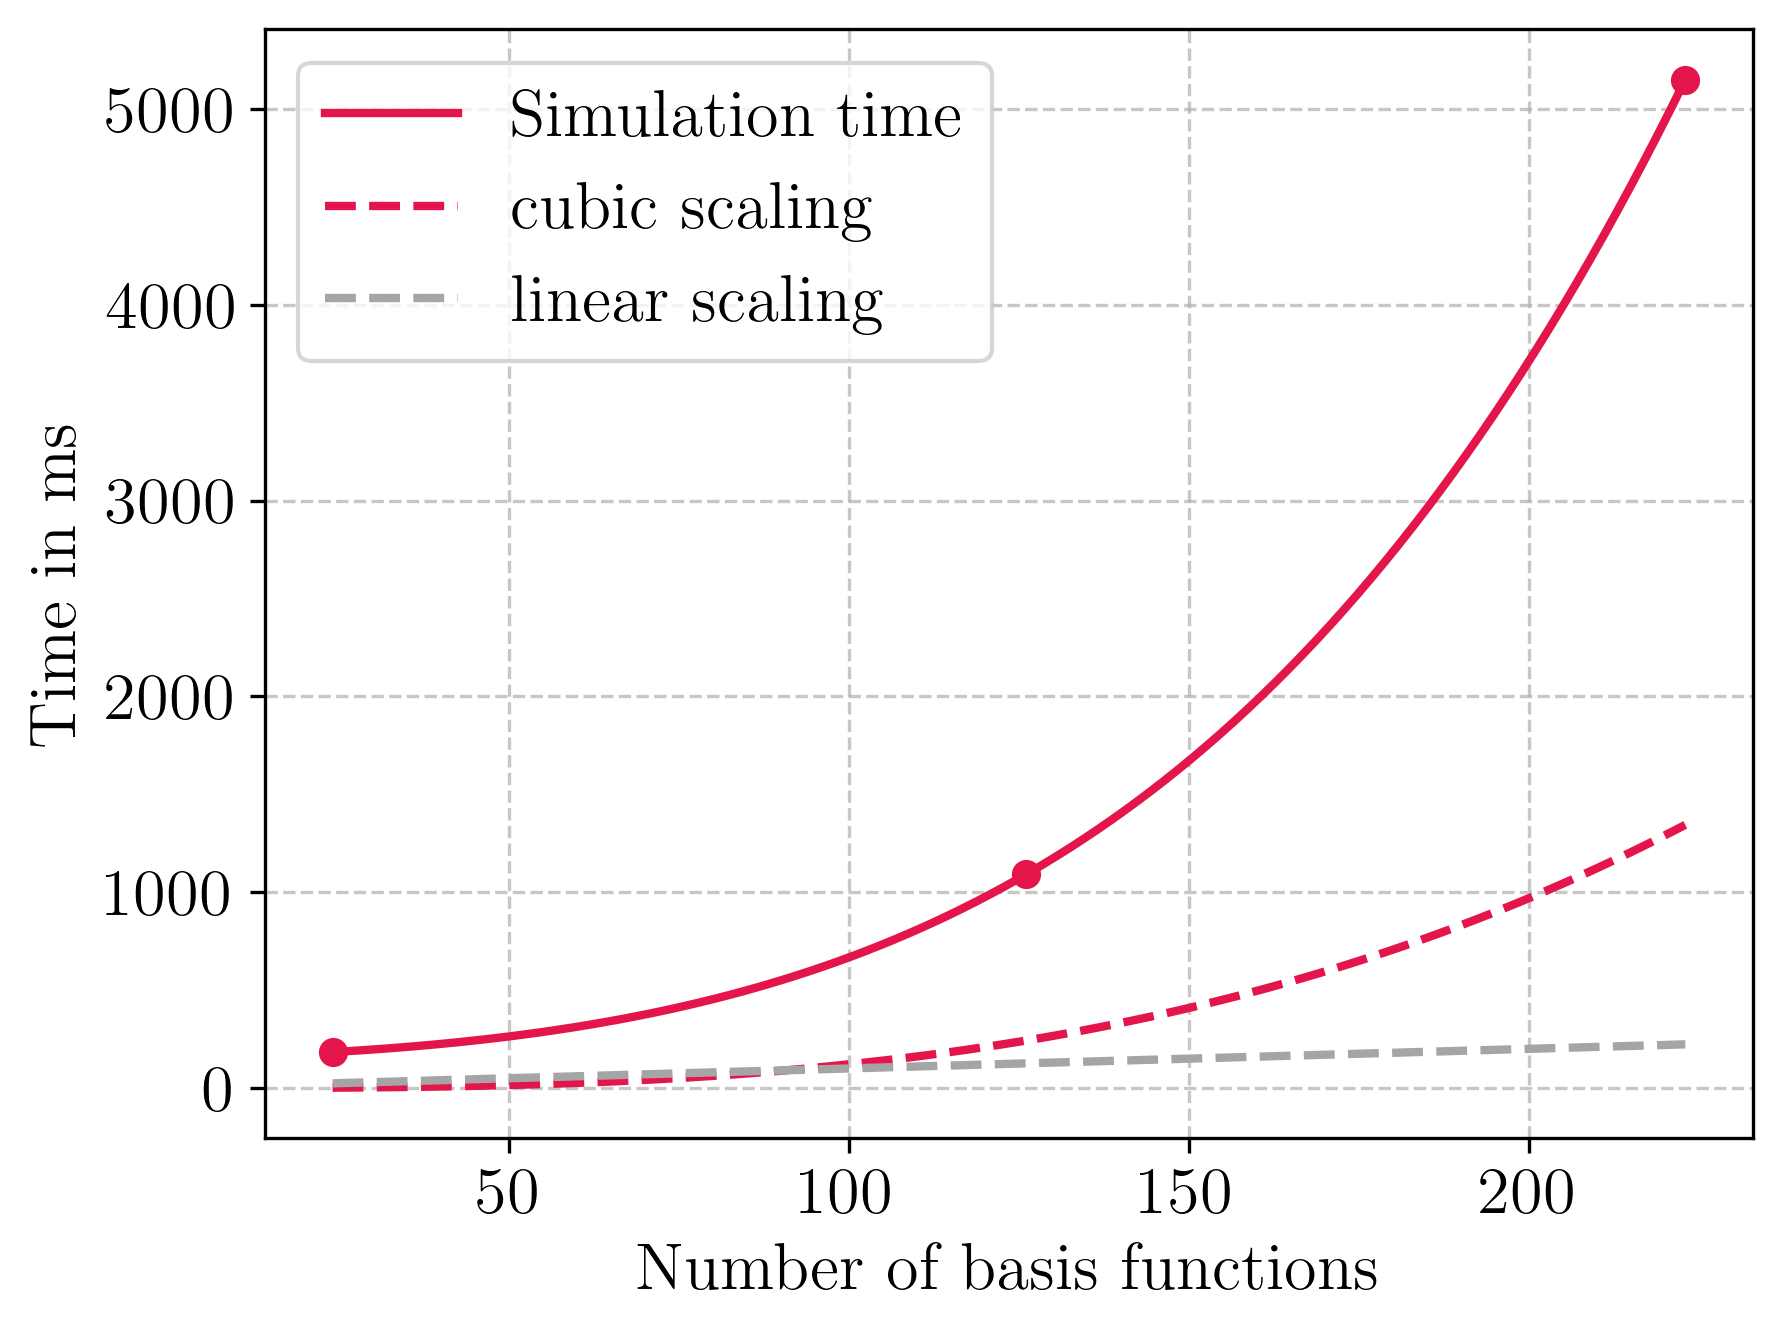

In [6]:
#poly fit
coeffs = np.polyfit(basis_functions, times, 4)
print("Polynomial coefficients:", coeffs)
plt.scatter(basis_functions, times)
x = np.linspace(min(basis_functions), max(basis_functions), 100)
plt.plot(x, np.polyval(coeffs, x), label="Simulation time")
plt.plot(x,1.21197672e-04*x**3, label="cubic scaling", linestyle='--', color=TU_RED)
plt.plot(x,x, label="linear scaling", linestyle='--', color=TU_GREY)
plt.xlabel("Number of basis functions")
plt.ylabel("Time in ms")
plt.legend()

# Gaussians

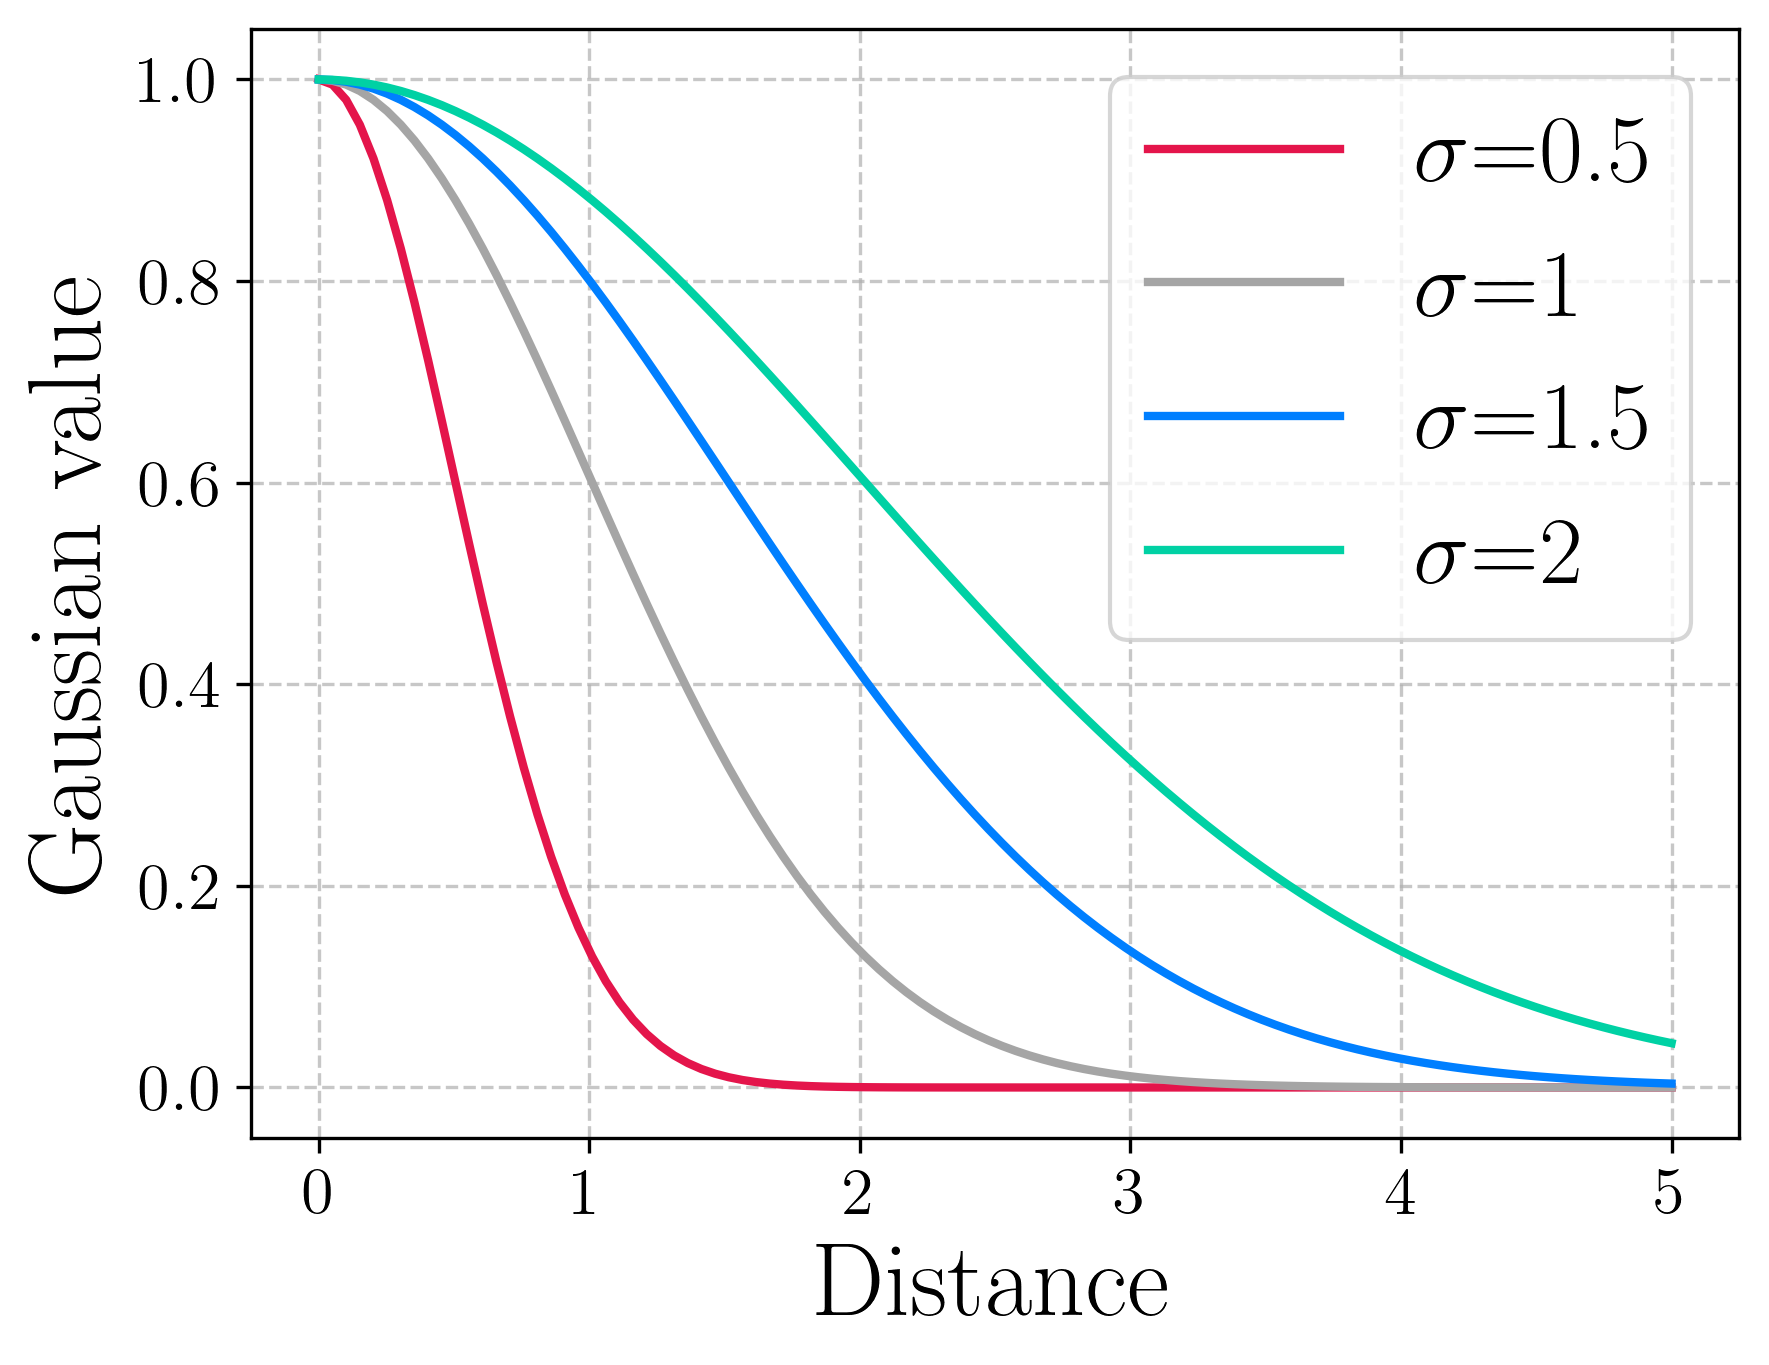

In [7]:
x = np.linspace(0, 5, 100) 
for sigma in [0.5, 1, 1.5, 2]:
    plt.plot(x, np.exp(-x**2/(2*sigma**2)), label=f"$\sigma$={sigma}")
plt.xlabel("Distance", fontsize=25)
plt.ylabel("Gaussian value", fontsize=25)
plt.legend(fontsize=23)

# Blocks

In [8]:
from scf_guess_tools import load, calculate, guess, Backend
from pyscf import gto, dft

In [9]:
filepath_h20 = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz/dsgdb9nsd_000003.xyz"

mol = load(filepath_h20, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")
density = wf.density()

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -75.6801116806426


In [13]:
mol = gto.Mole()
mol.atom = filepath_h20
mol.basis = "sto-3g"
mol.unit = 'Angstrom'
mol.charge = 0
mol.spin = 0
mol.symmetry = False
mol.build()

# RKS-DFT mit PBE
mf = dft.RKS(mol)
mf.xc = 'b3lypg'                # DFT-Funktional (z.B. 'B3LYP', 'PBE', 'LDA' ...)
mf.conv_tol = 1e-10           # Konvergenz-Toleranz
mf.kernel()
density = mf.make_rdm1()
density = density / density.max()
overlap = mf.get_ovlp()

converged SCF energy = -73.6465061604715


In [11]:
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg

from matplotlib.colors import SymLogNorm
def add_hatched_region(ax, row_start, row_end, col_start, col_end,
                       hatch='///', edgecolor='gray', linewidth=0):
    width  = col_end - col_start + 1
    height = row_end - row_start + 1
    rect = mpatches.Rectangle(
        (col_start - 0.5, row_start - 0.5),
        width, height,
        fill=False,
        hatch=hatch,
        edgecolor=edgecolor,
        linewidth=linewidth,
        alpha=0.5
    )
    ax.add_patch(rect)
def plotschematicBlocks(X, M, hatched_regions = [], colorbar=True, labelsize=8, vmax=1, overlay=None):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert
    norm = None#SymLogNorm(linthresh=1e-1, linscale=1.0, vmin=-vmax, vmax=vmax)

    im = ax[0].imshow(X, cmap='RdBu',vmax=vmax, vmin=-vmax)# norm=norm)


    labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: ${{{label.split()[2][:2]}}}$" for label in M.ao_labels()]
    ax[0].set_xticks(range(len(labels_)))
    ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
    ax[0].set_yticks(range(len(labels_)))
    ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
    ax[0].tick_params(axis='x', labelbottom=True, pad=60)
    ax[0].tick_params(axis='y', labelleft=True, pad=60)

    for label, hatch, row_col_indices in hatched_regions:
        row_start, row_end, col_start, col_end = row_col_indices
        add_hatched_region(ax[0], row_start, row_end, col_start, col_end, hatch=hatch)
        # add distinct hatch label to legend
        
    if hatched_regions:
     seen = {}
     handles = []
     for label, hatch, _ in hatched_regions:
         if hatch not in seen:
             seen[hatch] = label
             patch = mpatches.Patch(
                 facecolor='none',
                 hatch=hatch,
                 edgecolor='gray',
                 linewidth=1,
                 label=label
             )
             handles.append(patch)

     ax[0].legend(
         handles=handles,
         loc='lower center',
         bbox_to_anchor=(0.5, 0.99),
         ncol=len(handles),
         frameon=False,
         fontsize=labelsize
     )

    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color="black", lw=1.5)
        ax[0].axvline(b - 0.5, color="black", lw=1.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=labelsize)
        cb.ax.grid(False)
    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=0.21)
        ab = AnnotationBbox(imagebox, (0.69, 0.72), frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)
    plt.show()
    # plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)


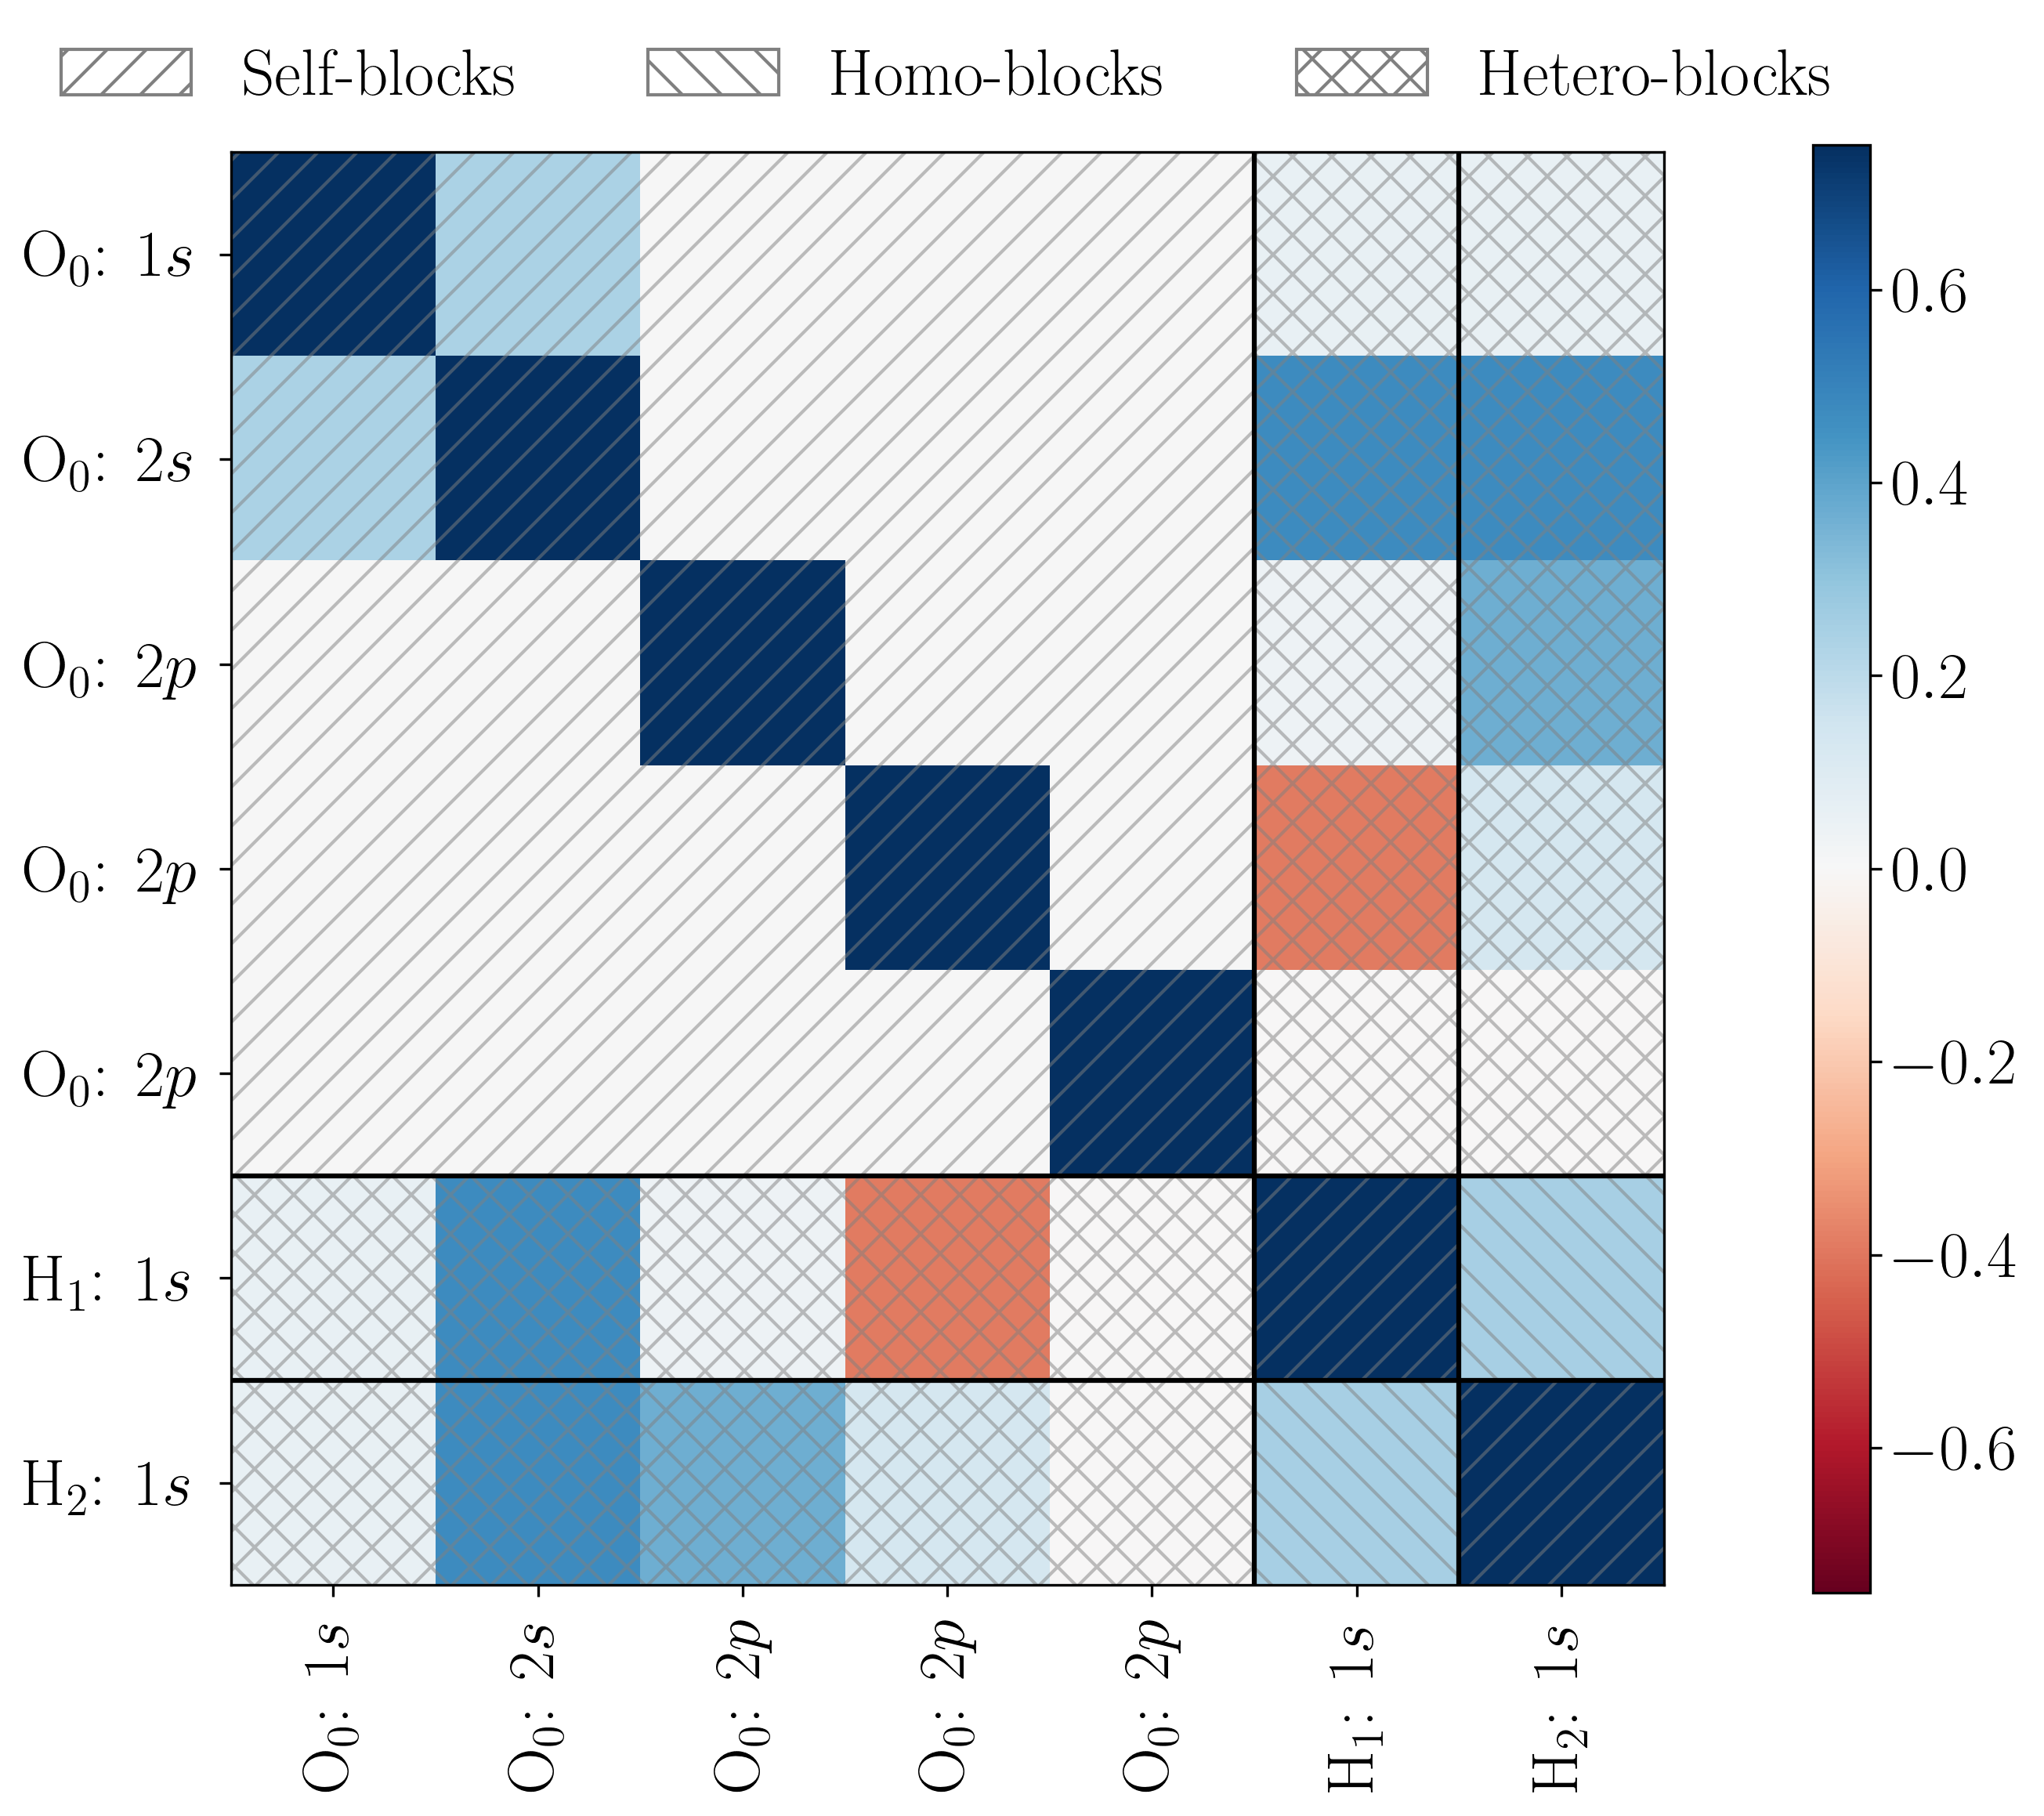

In [17]:
hatches = [
    ("Self-blocks", "//", (0, 4, 0, 4)),  
    ("Self-blocks", "//", (5, 5,  5, 5)),  
    ("Self-blocks", "//", ( 6, 6,  6, 6)),  
    ("Homo-blocks", "\\\\", ( 6, 6,  5, 5)),  
    ("Homo-blocks", "\\\\", ( 5, 5,  6, 6)),  
    ("Hetero-blocks", "xx", (0, 4,  5, 5)),  
    ("Hetero-blocks", "xx", (0, 4,  6, 6)),  
    ("Hetero-blocks", "xx", ( 5, 5, 0, 4)),  
    ("Hetero-blocks", "xx", ( 6, 6, 0, 4)),  
]
plotschematicBlocks(overlap, mol, vmax=0.75, hatched_regions=hatches, labelsize=20)# labels="atoms")

# Data Augmentation

In [18]:
test_mol_path = filepath_h20
# no rotation: 
mol_no_rot = load(test_mol_path, Backend.PY, basis="sto-3g")
points = []
with open(test_mol_path, 'r') as f:
    len_ = 0
    for i, line in enumerate(f):
        if len_ == 0: 
            len_ = float(line)
        if line.startswith('H') or line.startswith('O') or line.startswith('C\t'):
            points.append([float(x) for x in line.split()[1:4]])
        if i > len_: 
            break
wf_no_rot = calculate(mol_no_rot, "sto-3g", None, "dft", "b3lypg")
overlap_no_rot = wf_no_rot.overlap()
fock_no_rot = wf_no_rot.fock()
density_no_rot = wf_no_rot.density()

converged SCF energy = -74.3924315865336


In [19]:
def plotmat(X, M, colorbar=True, labelsize=8, vmax=1, title="", overlay=None, pos=None, zoom=None):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert

    im = ax[0].imshow(X, cmap='RdBu',vmax=vmax, vmin=-vmax)# norm=norm)


    labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: ${{{label.split()[2][:4]}}}$" for label in M.ao_labels()]
    ax[0].set_xticks(range(len(labels_)))
    ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
    ax[0].set_yticks(range(len(labels_)))
    ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
    ax[0].tick_params(axis='x', labelbottom=True, pad=70)
    ax[0].tick_params(axis='y', labelleft=True, pad=70)


    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color=TU_GREY, lw=1.5)
        ax[0].axvline(b - 0.5, color=TU_GREY, lw=1.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=labelsize)
        cb.ax.grid(False)
    ax[0].set_title(title, fontsize=labelsize*1.2, pad=10)
    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=zoom)
        ab = AnnotationBbox(imagebox, pos, frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)
    plt.show()

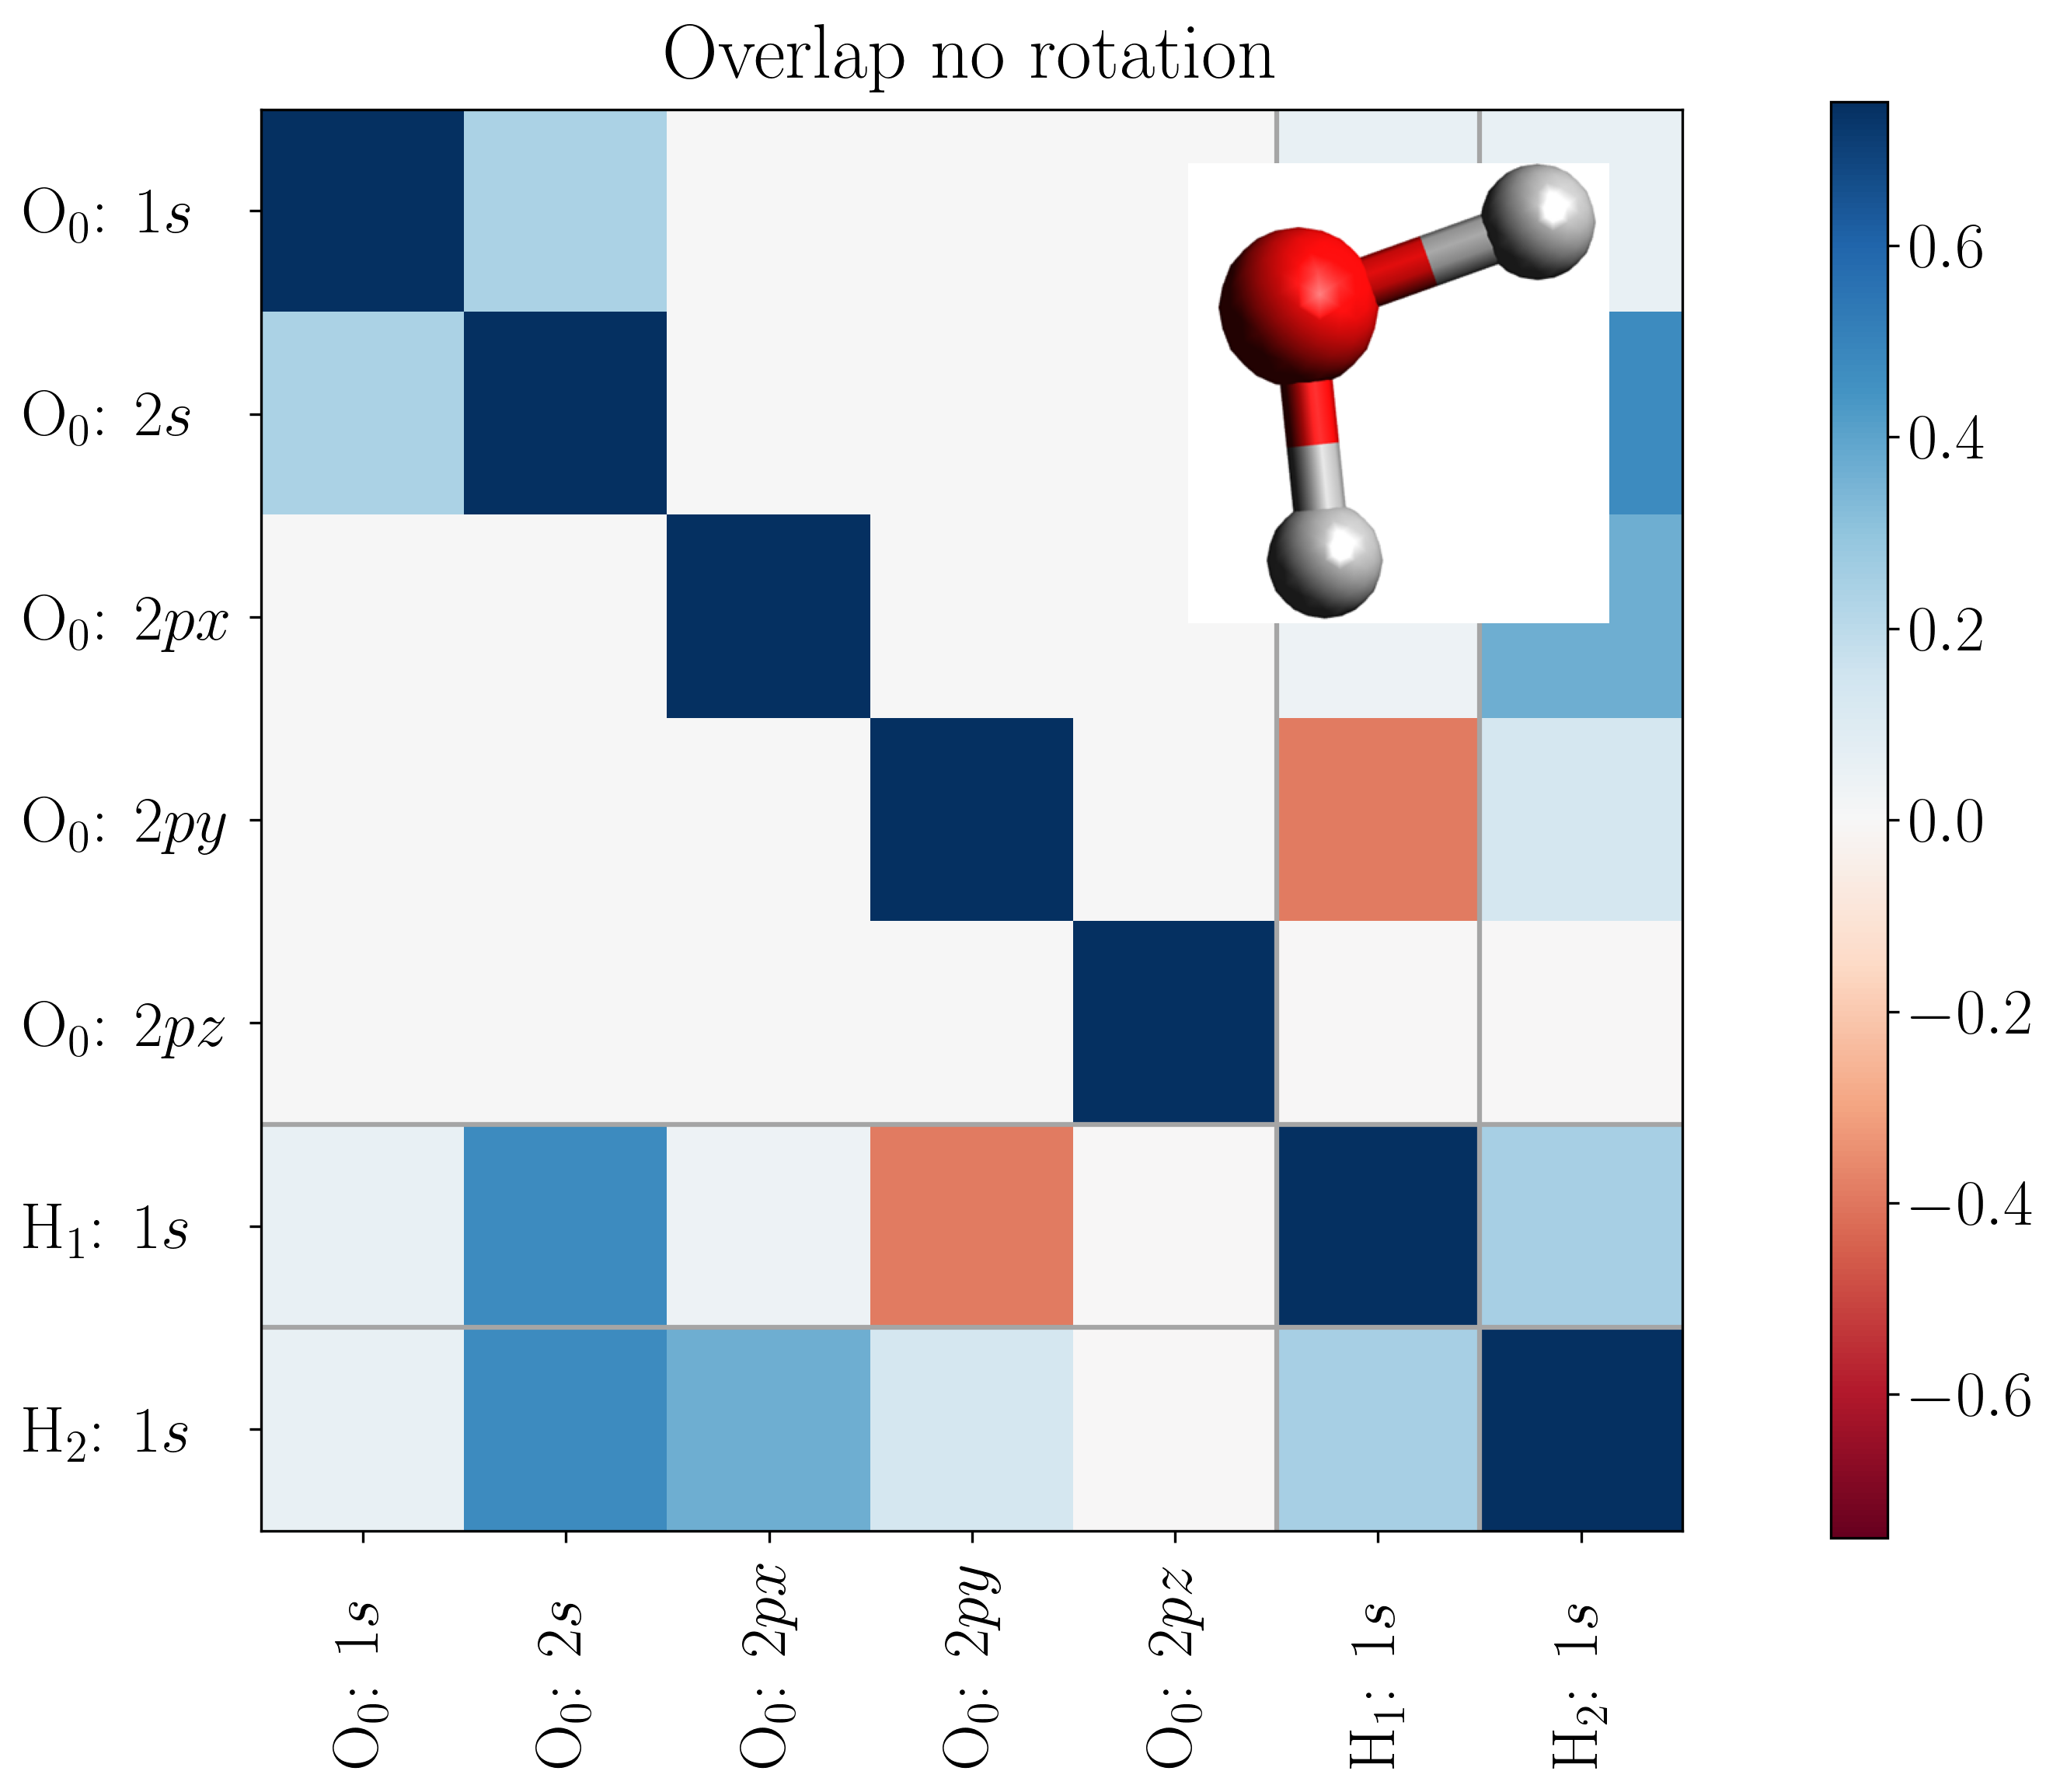

In [20]:
plotmat(overlap_no_rot.numpy,mol_no_rot.native, labelsize=20, vmax=0.75, title="Overlap no rotation", overlay= "/home/etschgi1/REPOS/Masterarbeit/latex/scripts/presentation/no_rot_h2o.png", pos=(0.8, 0.8), zoom=0.41)

No rotation: 
Axis: up is Z and to the right is X

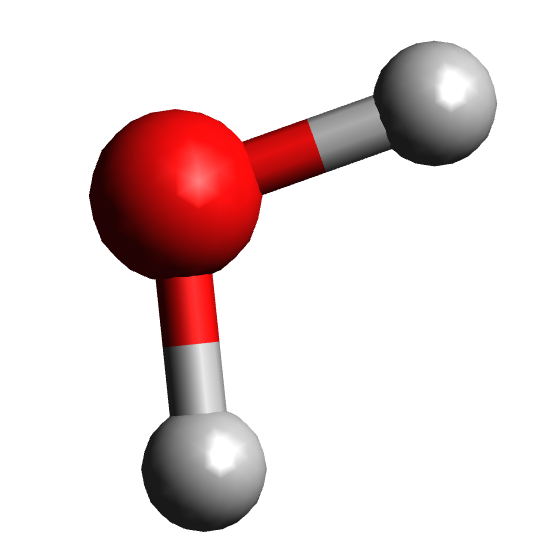

Rotated (axis same)

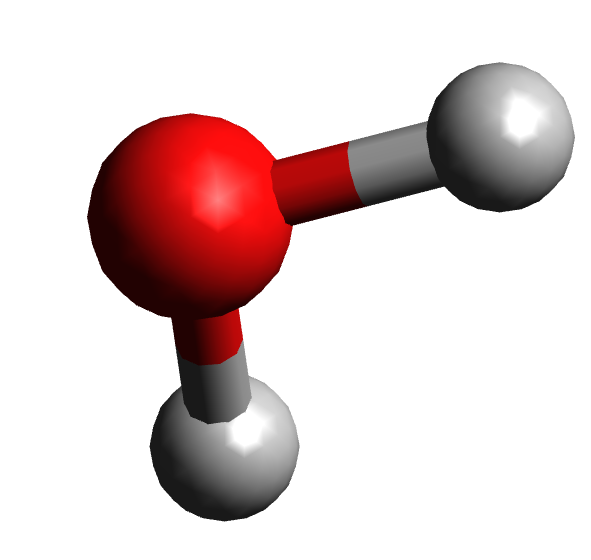


In [21]:
def quaternion_from_axis_angle(axis, angle):
    half_angle = angle / 2
    s = np.sin(half_angle)
    c = np.cos(half_angle)
    return np.quaternion(c, *(axis * s))

def rotate_points(points, axis, angle):
    """
    Rotates points around a given axis by a specified angle.

    Args:
        points (np.ndarray): shape (N, 3)
        axis (np.ndarray): rotation axis
        angle (float): rotation angle in radians

    Returns:
        np.ndarray: rotated points
    """
    q = np.quaternion(np.cos(angle / 2), *(axis * np.sin(angle / 2)))
    q_conjugate = q.conjugate()
    rotated_points = []
    for point in points:
        p = np.quaternion(0, *point)
        rotated_point = q * p * q_conjugate
        rotated_points.append(rotated_point.imag)
    return np.array(rotated_points)


In [22]:
# rotation around y-axis by 45 degrees
import os
rot_axis = np.array([1, 0, 0])
rot_axis = rot_axis / np.linalg.norm(rot_axis)  # Normalize the rotation axis
rot_angle = np.pi / 4  # 45 degrees in radians
rotated_points = rotate_points(np.array(points), rot_axis, rot_angle)
filename = os.path.split(test_mol_path)[-1]
data_folder = "/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/data"
atoms_ = [a for a, coord in mol_no_rot.native.atom]
rotated_test_mol_path = os.path.join(data_folder, filename.replace(".xyz", "_rotated.xyz"))

In [23]:
for points in rotated_points: 
    print(points)

[-0.0343605   0.68584972  0.6966    ]
[0.06476649 0.01346159 0.01563189]
[0.87179037 0.91930901 0.92028925]


In [24]:
with open(rotated_test_mol_path, 'w') as f:
    f.write(f"{len(rotated_points)}\n")
    f.write('Rotated molecule gdb 26124 charge 0 multiplicity 1\n')
    for i, point in enumerate(rotated_points):
        f.write(f"{atoms_[i]}\t{point[0]}\t{point[1]}\t{point[2]}\n")


In [25]:
# rotation: 
mol_rot = load(rotated_test_mol_path, Backend.PY, basis="sto-3g")
wf_rot = calculate(mol_rot, "sto-3g", None, "dft", "b3lypg")
overlap_rot = wf_rot.overlap()
fock_rot = wf_rot.fock()
density_rot = wf_rot.density()

converged SCF energy = -74.0040332681202


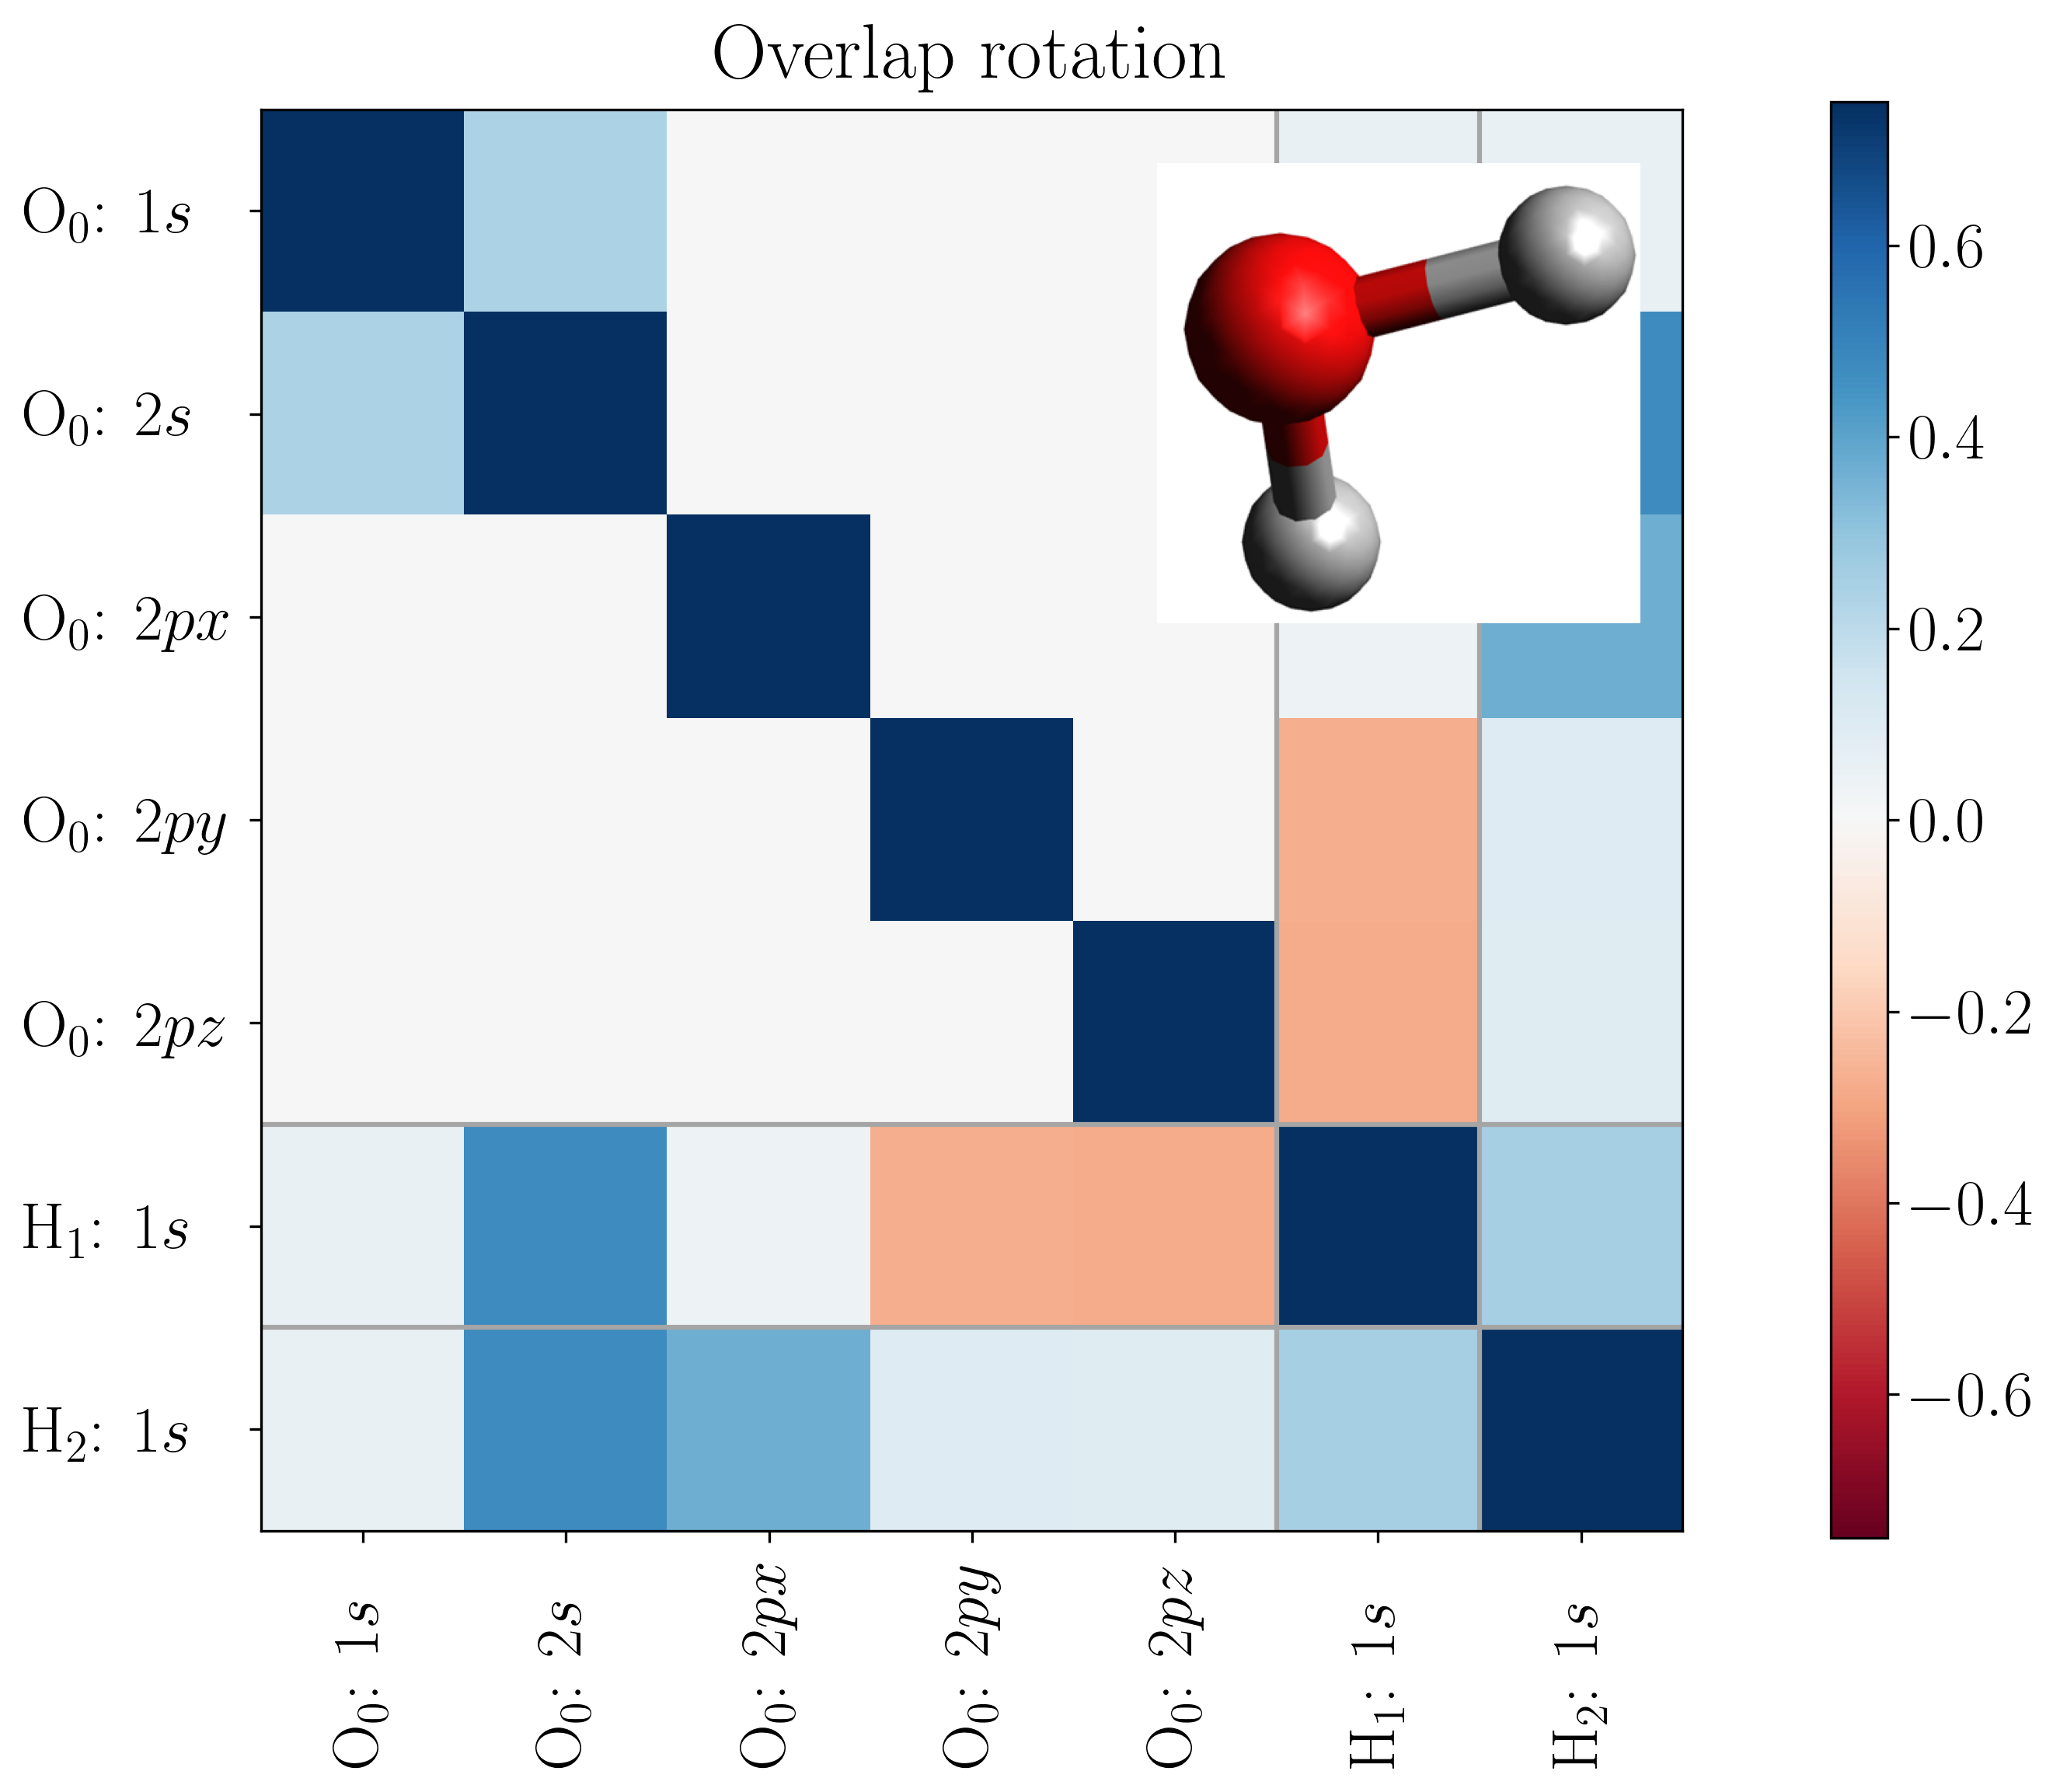

In [26]:
plotmat(overlap_rot.numpy, mol_rot.native, labelsize=20, vmax=0.75, title="Overlap rotation", overlay= "/home/etschgi1/REPOS/Masterarbeit/latex/scripts/presentation/rot_h2o.png", pos=(0.8, 0.8), zoom=0.41)